In [7]:
import os
import torch
import clip
from PIL import Image
from itertools import combinations

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    square_image = image.resize((224, 224), Image.LANCZOS)
    return square_image

def calculate_clip_similarity(folder_path):
    # Load the CLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    # Find all images in the folder
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]
    images = [load_and_preprocess_image(path) for path in image_paths]

    # Preprocess images and calculate features
    image_tensors = torch.cat([preprocess(image).unsqueeze(0).to(device) for image in images])
    print(image_tensors.shape)
    with torch.no_grad():
        image_features = model.encode_image(image_tensors).float()

    # Calculate similarity for each pair
    similarities = []
    for (img1, feature1), (img2, feature2) in combinations(zip(image_paths, image_features), 2):
        similarity = torch.nn.functional.cosine_similarity(feature1, feature2, dim=0).item()
        similarities.append((img1, img2, similarity))

    # Sort by similarity in descending order
    similarities.sort(key=lambda x: x[2], reverse=True)

    return similarities

# Example usage
folder_name = '/nlp/scr/zyanzhe/testset_manual_filtered'
similarities = calculate_clip_similarity(folder_name)

torch.Size([835, 3, 224, 224])


In [13]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images_side_by_side(image_path1, image_path2):
    # Load the images
    img1 = Image.open(image_path1)
    img2 = Image.open(image_path2)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Display the first image
    axes[0].imshow(img1)
    axes[0].axis('off')  # Turn off axis numbers and ticks
    axes[0].set_title('Image 1')

    # Display the second image
    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Image 2')

    # Show the plot
    plt.show()

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import torch
import clip
from tqdm import tqdm

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    square_image = image.resize((224, 224), Image.LANCZOS)
    return square_image


def process_images(folder, cluster_count):
    # Load the CLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    # Find all images in the folder
    image_paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Preprocess and extract features
    features = []
    for path in tqdm(image_paths, total=len(image_paths)):
        image = preprocess(load_and_preprocess_image(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            feature = model.encode_image(image)
        features.append(feature.cpu().numpy())

    features = np.vstack(features)

    # K-Means Clustering
    kmeans = KMeans(n_clusters=cluster_count, random_state=0).fit(features)

    # Find the closest image to each cluster centroid
    closest_images = []
    for center in kmeans.cluster_centers_:
        distances = np.linalg.norm(features - center, axis=1)
        closest_images.append(image_paths[np.argmin(distances)])

    return closest_images

# Example usage
closest_images = process_images('/nlp/scr/zyanzhe/testset_manual_filtered', 100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 835/835 [00:30<00:00, 27.18it/s]
/nlp/scr/zyanzhe/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [2]:
import numpy as np
closest_images = sorted(closest_images, key=lambda x: int(x.split("/")[-1][:-4]))

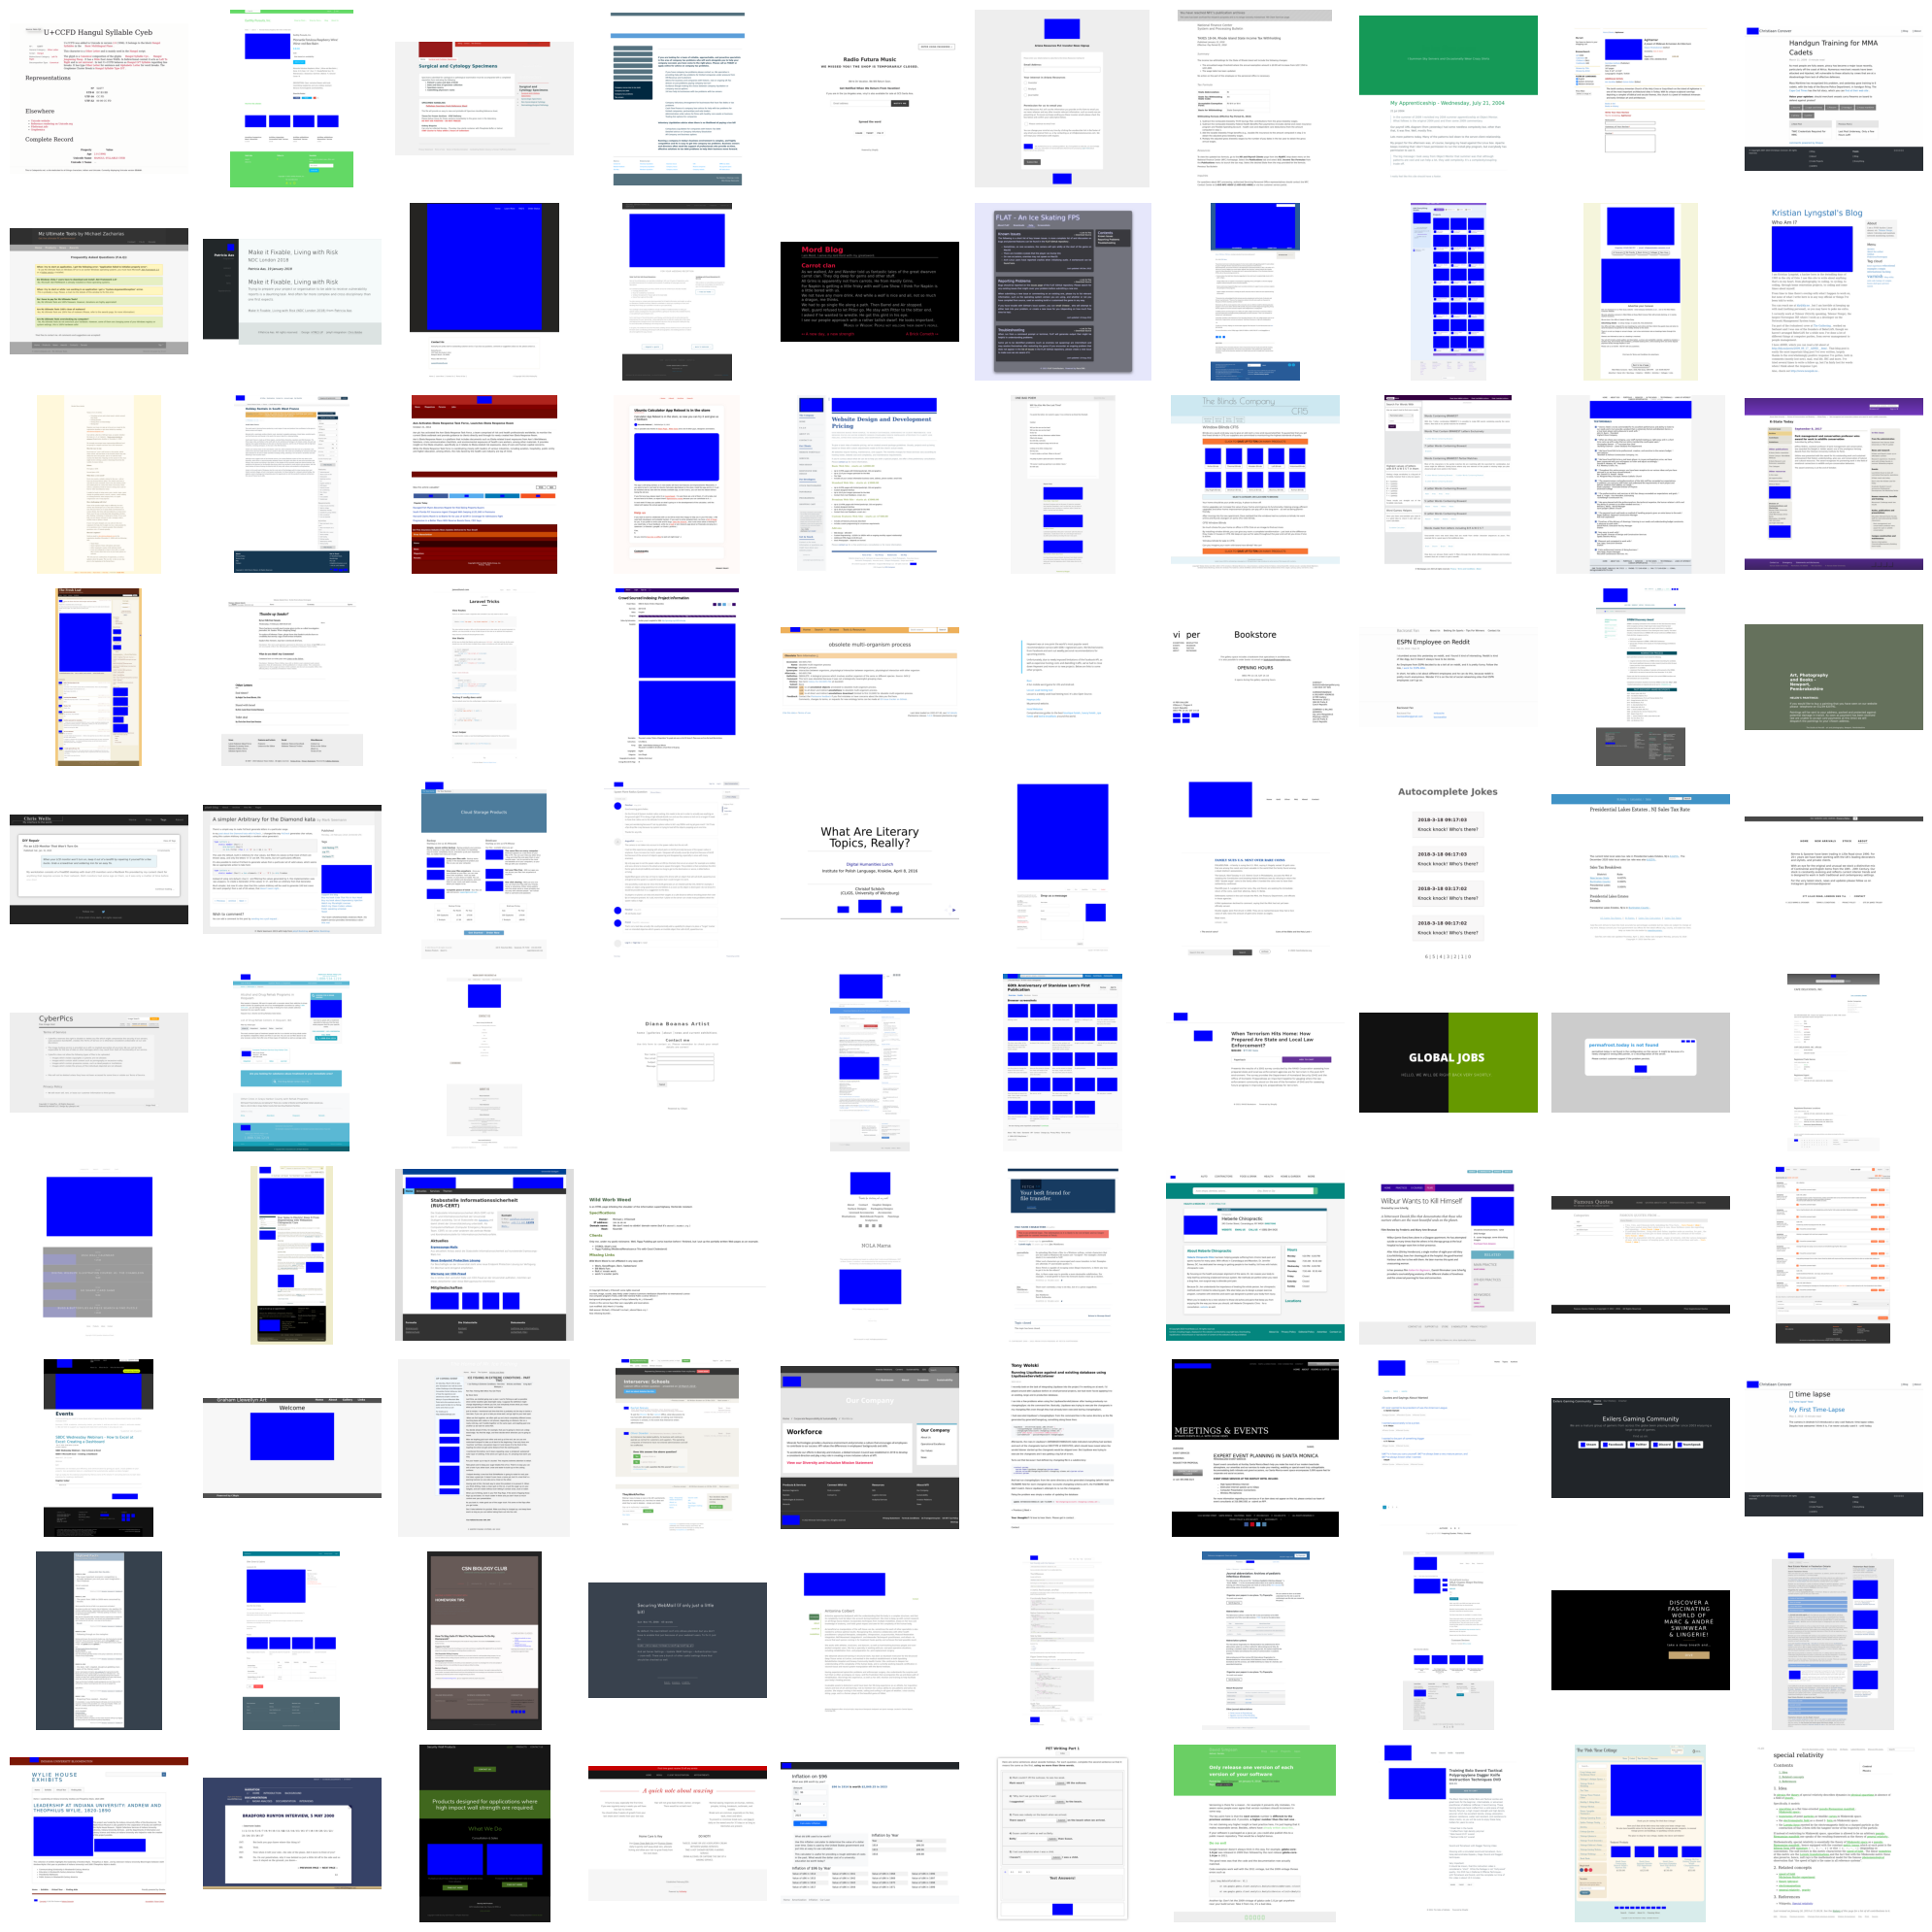

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images_in_grid(image_paths, grid_size=(10, 10)):
    if len(image_paths) != grid_size[0] * grid_size[1]:
        raise ValueError(f"Number of image paths must be exactly {grid_size[0] * grid_size[1]}")

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
    axes = axes.ravel()

    for i, img_path in enumerate(image_paths):
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_images_in_grid(closest_images)

In [5]:
for item in closest_images:
    new_item = item.replace("testset_manual_filtered", "testset_filtered_100")
    os.system(f"cp {item} {new_item}")
    item = item.replace("png", "html")
    new_item = new_item.replace("png", "html")
    os.system(f"cp {item} {new_item}")